This notebook is for:
1. analyzing downsampled synthetic SNP, INS, and DEL datasets.
2. analyzing downsampled sequenced isolates.

**To Do**

DONE ~~Correct DiscoSNP `variant_fof`, which currently points to 100X reads.~~

### SNPs only
**'dataset'** on the x-axis refers to downsampled coverages: 5x, 10x, 15x, 20x, 30x, 40x, 50x, 60x, 70x, 80, 90x. These are downsampled with `head -n [number of reads*4]` from the original 100x datasets.

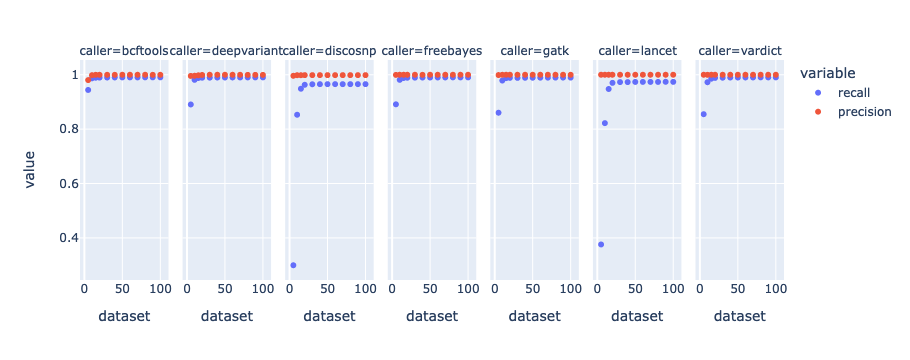

In [30]:
# Plot 
combinedsnpreads['dataset'] = pd.to_numeric(combinedsnpreads['dataset'], downcast='integer', errors='coerce')
fig = px.scatter(combinedsnpreads, x='dataset', y=['recall', 'precision'], facet_col='caller', 
                 category_orders={'caller': ['bcftools', 'deepvariant', 'discosnp', 'freebayes', 
                                             'gatk', 'lancet', 'vardict']})
fig

### INS only
**'dataset'** on the x-axis refers to downsampled coverages: 5x, 10x, 15x, 20x, 30x, 40x, 50x, 60x, 70x, 80, 90x. These are downsampled with `head -n [number of reads*4]` from the original 100x datasets.

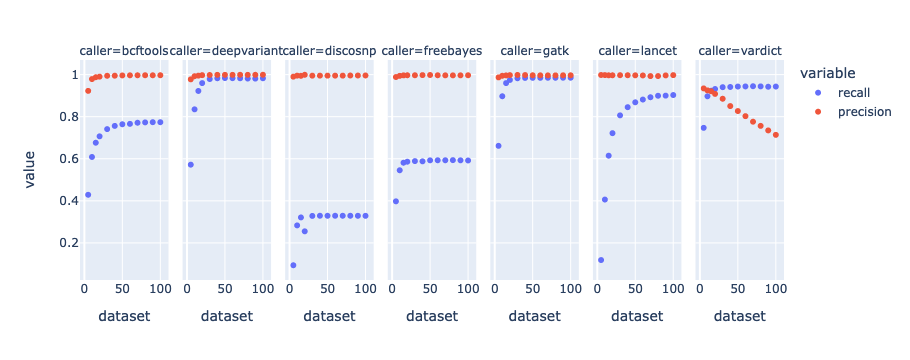

In [12]:
# Plot
fig = px.scatter(combinedINSreads, x='dataset', y=['recall', 'precision'], facet_col='caller', 
                 category_orders={'caller': ['bcftools', 'deepvariant', 'discosnp', 'freebayes', 
                                             'gatk', 'lancet', 'vardict']})
fig

### DEL only
**'dataset'** on the x-axis refers to downsampled coverages: 5x, 10x, 15x, 20x, 30x, 40x, 50x, 60x, 70x, 80, 90x. These are downsampled with `head -n [number of reads*4]` from the original 100x datasets.

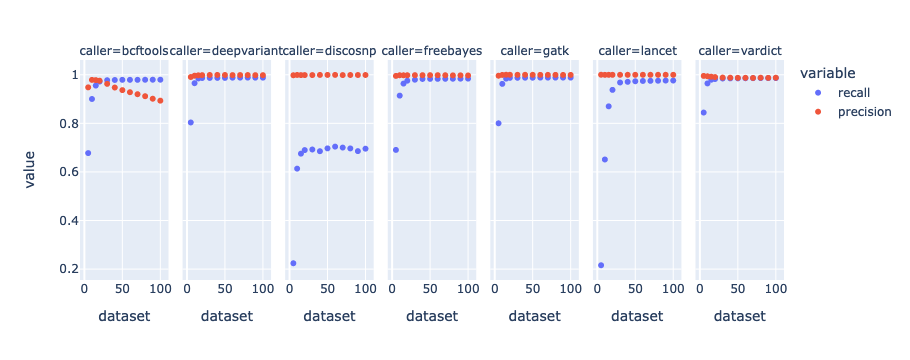

In [23]:
combinedDELreads['dataset'] = pd.to_numeric(combinedDELreads['dataset'], downcast='integer', errors='coerce')
fig = px.scatter(combinedDELreads, x='dataset', y=['recall', 'precision'], facet_col='caller', 
                 category_orders={'caller': ['bcftools', 'deepvariant', 'discosnp', 'freebayes', 
                                             'gatk', 'lancet', 'vardict']})
fig

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import bamboolib as bam
import plotly.express as px

In [3]:
def filter_df(df, filter_column=None, min_value=None):
    '''
    df: from csv generated by testing pipeline, via checker.py
    filter_column: string of column name to filter by
    min_value: minimum threshold for values to retain when filtering by filter_column
    '''
    if filter_column == 'DP':
        filtered = df[(df[filter_column] >= min_value) | df[filter_column].isna() & (df['BAM_DP'] >= min_value)]
        filtered['dataset'] = filter_column + '>=' + str(min_value)
    elif filter_column != None:
        filtered = df[(df[filter_column] >= min_value) | (df[filter_column].isna())]
        filtered['dataset'] = filter_column + '>=' + str(min_value)
    else:
        filtered = df
        filtered['dataset'] = np.nan
    return filtered

def sum_filtered(filtered, variantlog=None, logrow=2):
    '''
    filtered: from csv generated by testing pipeline, via checker.py, or from filter_df
    variantlog: variant output log generated by testing pipeline, via variants.py
    logrow: row to get total mutations from (0-start)
    '''
    sums = {}
    for tool in set(filtered['TOOL']):
        sums[tool] = [sum(filtered.loc[filtered['TOOL'] == tool, 'TRUE_POS']),
                      sum(filtered.loc[filtered['TOOL'] == tool, 'FALSE_POS']),
                      sum(filtered.loc[filtered['TOOL'] == tool, 'FALSE_NEG'])]
    filtered_sums = pd.DataFrame(data=sums).T
    filtered_sums.reset_index(inplace=True)
    filtered_sums.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
    filtered_sums['recall'] = filtered_sums['true_pos'] / (filtered_sums['true_pos'] + filtered_sums['false_neg'])
    filtered_sums['precision'] = filtered_sums['true_pos'] / (filtered_sums['true_pos'] + filtered_sums['false_pos'])
    filtered_sums['dataset'] = filtered['dataset']
    
    # Sanity check: When min_value = 0, introduced mutations == postfilter mutations
    if variantlog is not None:
        with open(variantlog, 'r') as log:
            varsettings = log.readlines()
        filtered_sums['total_mut_intro'] = int(varsettings[logrow].split(':')[-1].strip())
        filtered_sums['total_mut_postfilter'] = filtered_sums['true_pos'] + filtered_sums['false_neg']
    else:
        filtered_sums['total_mut_intro'] = np.nan
        filtered_sums['total_mut_postfilter'] = np.nan
    
    return filtered_sums

def combine_filtered(df, filter_column, filter_min, filter_max, filter_step, variantlog=None, logrow=2):
    filtered_dfs = []
    for threshold in range(filter_min, filter_max + filter_step, filter_step):
        summarydf = sum_filtered(filter_df(df, filter_column, filter_min), variantlog, logrow)
        filtered_dfs.append(summarydf)
    combined_summaries = pd.concat(filtered_dfs, ignore_index=True)
    return combined_summaries

### Import datasets - 100X

In [4]:
# Called datasets - 100X average read depths
snp100x = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3SNP100X_alltools_normalized_dp0_H37Rv_checked.csv')
ins100x = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3INS100X_alltools_normalized_dp0_H37Rv_checked.csv')
del100x = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3DEL100X_alltools_normalized_dp0_H37Rv_checked.csv')

#### SNPs only

In [24]:
# Downsampled reads from SNP 100X
snp90xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3SNPhead90X_alltools_normalized_dp0_H37Rv_checked.csv')
snp80xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3SNPhead80X_alltools_normalized_dp0_H37Rv_checked.csv')
snp70xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3SNPhead70X_alltools_normalized_dp0_H37Rv_checked.csv')
snp60xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3SNPhead60X_alltools_normalized_dp0_H37Rv_checked.csv')
snp50xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3SNPhead50X_alltools_normalized_dp0_H37Rv_checked.csv')
snp40xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3SNPhead40X_alltools_normalized_dp0_H37Rv_checked.csv')
snp30xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3SNPhead30X_alltools_normalized_dp0_H37Rv_checked.csv')
snp20xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3SNPhead20X_alltools_normalized_dp0_H37Rv_checked.csv')
snp15xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3SNPhead15X_alltools_normalized_dp0_H37Rv_checked.csv')
snp10xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3SNPhead10X_alltools_normalized_dp0_H37Rv_checked.csv')
snp5xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3SNPhead5X_alltools_normalized_dp0_H37Rv_checked.csv')

In [25]:
snp100xsummary = sum_filtered(filter_df(snp100x), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3SNP100X.log')
snp90xreadssummary = sum_filtered(filter_df(snp90xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3SNP100X.log')
snp80xreadssummary = sum_filtered(filter_df(snp80xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3SNP100X.log')
snp70xreadssummary = sum_filtered(filter_df(snp70xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3SNP100X.log')
snp60xreadssummary = sum_filtered(filter_df(snp60xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3SNP100X.log')
snp50xreadssummary = sum_filtered(filter_df(snp50xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3SNP100X.log')
snp40xreadssummary = sum_filtered(filter_df(snp40xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3SNP100X.log')
snp30xreadssummary = sum_filtered(filter_df(snp30xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3SNP100X.log')
snp20xreadssummary = sum_filtered(filter_df(snp20xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3SNP100X.log')
snp15xreadssummary = sum_filtered(filter_df(snp15xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3SNP100X.log')
snp10xreadssummary = sum_filtered(filter_df(snp10xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3SNP100X.log')
snp5xreadssummary = sum_filtered(filter_df(snp5xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3SNP100X.log')

In [26]:
datasets = [snp5xreadssummary, snp10xreadssummary, snp15xreadssummary, snp20xreadssummary, 
            snp30xreadssummary, snp40xreadssummary, snp50xreadssummary, snp60xreadssummary, 
            snp70xreadssummary, snp80xreadssummary, snp90xreadssummary, snp100xsummary]

In [27]:
snp5xreadssummary[['dataset']] = snp5xreadssummary[['dataset']].fillna(5)
snp10xreadssummary[['dataset']] = snp10xreadssummary[['dataset']].fillna(10)
snp15xreadssummary[['dataset']] = snp15xreadssummary[['dataset']].fillna(15)
snp20xreadssummary[['dataset']] = snp20xreadssummary[['dataset']].fillna(20)
snp30xreadssummary[['dataset']] = snp30xreadssummary[['dataset']].fillna(30)
snp40xreadssummary[['dataset']] = snp40xreadssummary[['dataset']].fillna(40)
snp50xreadssummary[['dataset']] = snp50xreadssummary[['dataset']].fillna(50)
snp60xreadssummary[['dataset']] = snp60xreadssummary[['dataset']].fillna(60)
snp70xreadssummary[['dataset']] = snp70xreadssummary[['dataset']].fillna(70)
snp80xreadssummary[['dataset']] = snp80xreadssummary[['dataset']].fillna(80)
snp90xreadssummary[['dataset']] = snp90xreadssummary[['dataset']].fillna(90)
snp100xsummary[['dataset']] = snp100xsummary[['dataset']].fillna(100)

In [28]:
combinedsnpreads = pd.concat(datasets, ignore_index=True)

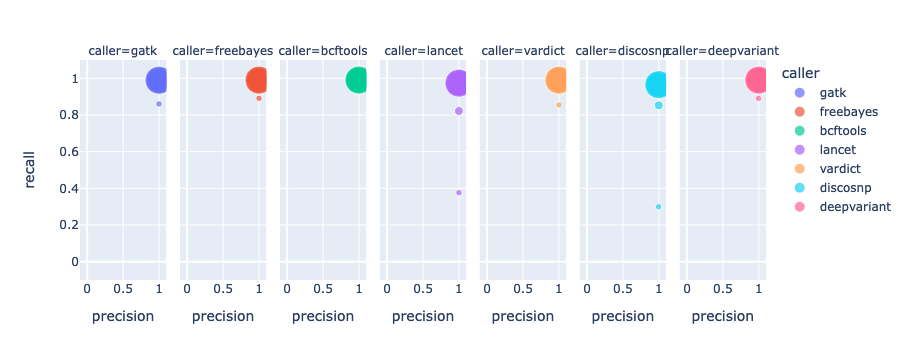

In [29]:
# Plot
fig = px.scatter(combinedsnpreads, x='precision', y='recall', color='caller', facet_col='caller', range_y=(-0.1, 1.1), range_x=(-0.1, 1.1), size='dataset')
fig

#### INS only

In [5]:
# Downsampled reads from INS 100X
ins90xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3INShead90X_alltools_normalized_dp0_H37Rv_checked.csv')
ins80xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3INShead80X_alltools_normalized_dp0_H37Rv_checked.csv')
ins70xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3INShead70X_alltools_normalized_dp0_H37Rv_checked.csv')
ins60xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3INShead60X_alltools_normalized_dp0_H37Rv_checked.csv')
ins50xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3INShead50X_alltools_normalized_dp0_H37Rv_checked.csv')
ins40xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3INShead40X_alltools_normalized_dp0_H37Rv_checked.csv')
ins30xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3INShead30X_alltools_normalized_dp0_H37Rv_checked.csv')
ins20xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3INShead20X_alltools_normalized_dp0_H37Rv_checked.csv')
ins15xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3INShead15X_alltools_normalized_dp0_H37Rv_checked.csv')
ins10xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3INShead10X_alltools_normalized_dp0_H37Rv_checked.csv')
ins5xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3INShead5X_alltools_normalized_dp0_H37Rv_checked.csv')

In [6]:
ins100xsummary = sum_filtered(filter_df(ins100x), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3INS100X.log')
ins90xreadssummary = sum_filtered(filter_df(ins90xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3INS100X.log')
ins80xreadssummary = sum_filtered(filter_df(ins80xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3INS100X.log')
ins70xreadssummary = sum_filtered(filter_df(ins70xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3INS100X.log')
ins60xreadssummary = sum_filtered(filter_df(ins60xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3INS100X.log')
ins50xreadssummary = sum_filtered(filter_df(ins50xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3INS100X.log')
ins40xreadssummary = sum_filtered(filter_df(ins40xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3INS100X.log')
ins30xreadssummary = sum_filtered(filter_df(ins30xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3INS100X.log')
ins20xreadssummary = sum_filtered(filter_df(ins20xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3INS100X.log')
ins15xreadssummary = sum_filtered(filter_df(ins15xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3INS100X.log')
ins10xreadssummary = sum_filtered(filter_df(ins10xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3INS100X.log')
ins5xreadssummary = sum_filtered(filter_df(ins5xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3INS100X.log')

In [7]:
# Add missing data
ins5xreadssummary[['dataset']] = ins5xreadssummary[['dataset']].fillna(5)
ins10xreadssummary[['dataset']] = ins10xreadssummary[['dataset']].fillna(10)
ins15xreadssummary[['dataset']] = ins15xreadssummary[['dataset']].fillna(15)
ins20xreadssummary[['dataset']] = ins20xreadssummary[['dataset']].fillna(20)
ins30xreadssummary[['dataset']] = ins30xreadssummary[['dataset']].fillna(30)
ins40xreadssummary[['dataset']] = ins40xreadssummary[['dataset']].fillna(40)
ins50xreadssummary[['dataset']] = ins50xreadssummary[['dataset']].fillna(50)
ins60xreadssummary[['dataset']] = ins60xreadssummary[['dataset']].fillna(60)
ins70xreadssummary[['dataset']] = ins70xreadssummary[['dataset']].fillna(70)
ins80xreadssummary[['dataset']] = ins80xreadssummary[['dataset']].fillna(80)
ins90xreadssummary[['dataset']] = ins90xreadssummary[['dataset']].fillna(90)
ins100xsummary[['dataset']] = ins100xsummary[['dataset']].fillna(100)

In [8]:
ins_datasets = [ins5xreadssummary, ins10xreadssummary, ins15xreadssummary, ins20xreadssummary,
                ins30xreadssummary, ins40xreadssummary, 
                ins50xreadssummary, ins60xreadssummary, ins70xreadssummary, ins80xreadssummary, ins90xreadssummary,
                ins100xsummary]

In [9]:
combinedINSreads = pd.concat(ins_datasets, ignore_index=True)

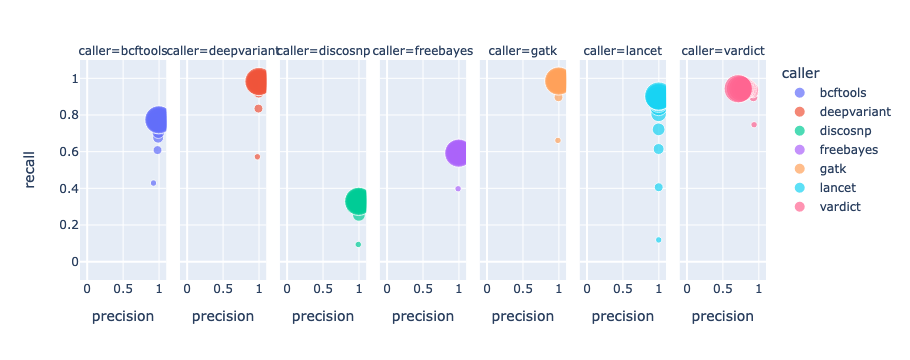

In [16]:
# Plot
fig = px.scatter(combinedINSreads, x='precision', y='recall', range_x=(-0.1, 1.1), range_y=(-0.1, 1.1), 
                 color='caller', facet_col='caller', 
                 category_orders={'caller': ['bcftools', 'deepvariant', 'discosnp', 'freebayes', 
                                             'gatk', 'lancet', 'vardict']}, size='dataset')
fig

#### DEL only

In [17]:
# Downsampled reads from DEL 100X
del90xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3DELhead90X_alltools_normalized_dp0_H37Rv_checked.csv')
del80xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3DELhead80X_alltools_normalized_dp0_H37Rv_checked.csv')
del70xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3DELhead70X_alltools_normalized_dp0_H37Rv_checked.csv')
del60xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3DELhead60X_alltools_normalized_dp0_H37Rv_checked.csv')
del50xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3DELhead50X_alltools_normalized_dp0_H37Rv_checked.csv')
del40xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3DELhead40X_alltools_normalized_dp0_H37Rv_checked.csv')
del30xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3DELhead30X_alltools_normalized_dp0_H37Rv_checked.csv')
del20xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3DELhead20X_alltools_normalized_dp0_H37Rv_checked.csv')
del15xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3DELhead15X_alltools_normalized_dp0_H37Rv_checked.csv')
del10xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3DELhead10X_alltools_normalized_dp0_H37Rv_checked.csv')
del5xreads = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3DELhead5X_alltools_normalized_dp0_H37Rv_checked.csv')

In [18]:
del100xsummary = sum_filtered(filter_df(del100x), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3DEL100X.log')
del90xreadssummary = sum_filtered(filter_df(del90xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3DEL100X.log')
del80xreadssummary = sum_filtered(filter_df(del80xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3DEL100X.log')
del70xreadssummary = sum_filtered(filter_df(del70xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3DEL100X.log')
del60xreadssummary = sum_filtered(filter_df(del60xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3DEL100X.log')
del50xreadssummary = sum_filtered(filter_df(del50xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3DEL100X.log')
del40xreadssummary = sum_filtered(filter_df(del40xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3DEL100X.log')
del30xreadssummary = sum_filtered(filter_df(del30xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3DEL100X.log')
del20xreadssummary = sum_filtered(filter_df(del20xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3DEL100X.log')
del15xreadssummary = sum_filtered(filter_df(del15xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3DEL100X.log')
del10xreadssummary = sum_filtered(filter_df(del10xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3DEL100X.log')
del5xreadssummary = sum_filtered(filter_df(del5xreads), '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3DEL100X.log')

In [19]:
# Add missing data
del5xreadssummary[['dataset']] = del5xreadssummary[['dataset']].fillna(5)
del10xreadssummary[['dataset']] = del10xreadssummary[['dataset']].fillna(10)
del15xreadssummary[['dataset']] = del15xreadssummary[['dataset']].fillna(15)
del20xreadssummary[['dataset']] = del20xreadssummary[['dataset']].fillna(20)
del30xreadssummary[['dataset']] = del30xreadssummary[['dataset']].fillna(30)
del40xreadssummary[['dataset']] = del40xreadssummary[['dataset']].fillna(40)
del50xreadssummary[['dataset']] = del50xreadssummary[['dataset']].fillna(50)
del60xreadssummary[['dataset']] = del60xreadssummary[['dataset']].fillna(60)
del70xreadssummary[['dataset']] = del70xreadssummary[['dataset']].fillna(70)
del80xreadssummary[['dataset']] = del80xreadssummary[['dataset']].fillna(80)
del90xreadssummary[['dataset']] = del90xreadssummary[['dataset']].fillna(90)
del100xsummary[['dataset']] = del100xsummary[['dataset']].fillna(100)

In [20]:
del_datasets = [del5xreadssummary, del10xreadssummary, del15xreadssummary, 
                del20xreadssummary, del30xreadssummary, del40xreadssummary, 
                del50xreadssummary, del60xreadssummary, del70xreadssummary, 
                del80xreadssummary, del90xreadssummary, del100xsummary]

In [21]:
combinedDELreads = pd.concat(del_datasets, ignore_index=True)

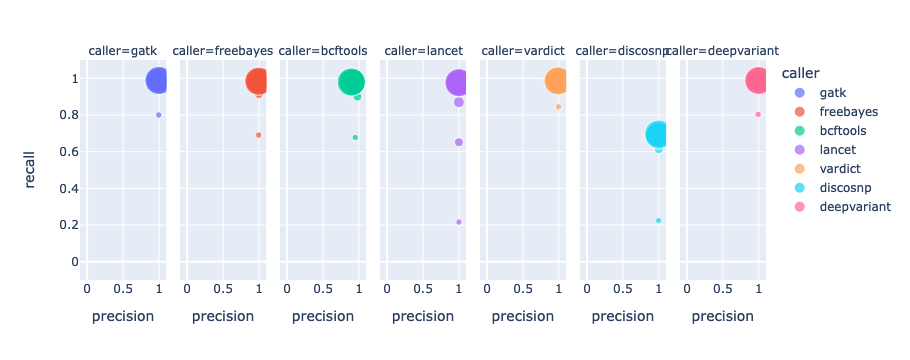

In [22]:
fig = px.scatter(combinedDELreads, x='precision', y='recall', color='caller', facet_col='caller', range_x=(-0.1, 1.1), range_y=(-0.1, 1.1), size='dataset')
fig

In [4]:
# From 100X, subsampled from BAM
snp50xBAM = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv_10-3SNPsub50X_alltools_normalized_dp0_H37Rv_checked.csv')

In [ ]:
snp50xBAMsummary = sum_filtered(snp50xBAM, 'BAM_DP', 0, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv_10-3SNP100X.log')

In [ ]:
combinedsnpBAM = pd.concat([snp100x, snp50xBAM], ignore_index=True)